In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


# Objective
The kernel is to learn basics of EDA


# Input modules

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import time
import sys
import gc
import pickle
import datetime
from datetime import datetime, date
sys.version_info

sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)

# Data input and exploring

In [108]:
df_train=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
items=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
shops=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
cats=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')


# Print out the basic information of training dataset

In [109]:
print("Top5 Record\n", df_train.head(5),'\n')
print("Basic Information")
print(df_train.info())
print("\nData Type")
print(df_train.dtypes)
print("\nMissing Valus")
print(df_train.isnull().sum())
print("\nShape of Data")
print(df_train.shape)


Top5 Record
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0 

Basic Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None

Data Type
date               object
date_block_num      int64
shop_id             int64
item_id             i

We find 6 duplicates among 3 millions records, that is quite possible 

In [110]:
print("Duplicated Data\n", df_train[df_train.duplicated()])

Duplicated Data
                date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013               0       54    20130       149.0   
1435367  23.02.2014              13       50     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   
1866340  12.07.2014              18       25     3423       999.0   
2198566  31.12.2014              23       42    21619       499.0   

         item_cnt_day  
76962             1.0  
1435367           1.0  
1496766           1.0  
1671873           1.0  
1866340           1.0  
2198566           1.0  


An useful practice of downcasting the memory usage of dataframe.

In [111]:
def downcast_dtypes(df):
    float_cols=[col for col in df if df[col].dtype=="float64"]
    int_cols=[col for col in df if df[col].dtype in ["int64","int32"]]
    df[float_cols]=df[float_cols].astype(np.float32)
    df[int_cols]=df[int_cols].astype(np.int16)
    return df
# down cast the training dataset(this code better to be ran once)
df_train=downcast_dtypes(df_train)

In [112]:
print(df_train.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


# 1. EDA by each data column
EDA by columns should be a basic option for data exploring, simple and straight forward

## 1.1 Item_id

In [113]:
df_by_item_id=df_train.pivot_table(index=['item_id'], columns='date_block_num',values=['item_cnt_day'], aggfunc=np.sum, fill_value=0).reset_index()
df_by_item_id.columns=df_by_item_id.columns.droplevel().map(str)
df_by_item_id=df_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
df_by_item_id.columns.values[0]='item_id'


### looks like the end or start of the year has sale peak, 

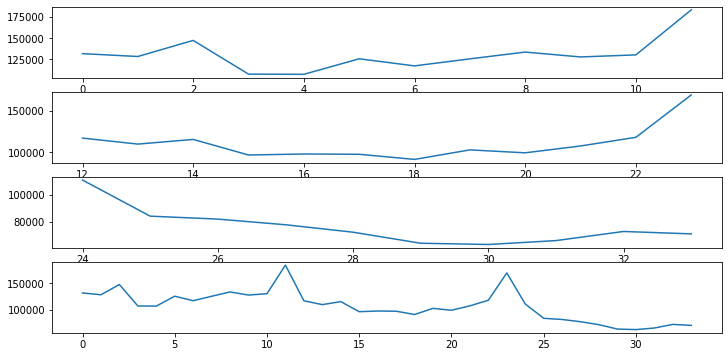

In [114]:
fig, axes =plt.subplots(4,1,figsize=(12,6))
df_by_item_id.sum()[1:13].plot(ax=axes[0])
df_by_item_id.sum()[13:25].plot(ax=axes[1])
df_by_item_id.sum()[25:].plot(ax=axes[2])
df_by_item_id.sum()[1:].plot(ax=axes[3])
plt.show()

In [115]:
df_by_item_id.sum()

item_id    242029335
0             131479
1             128090
2             147142
3             107190
4             106970
5             125381
6             116966
7             125291
8             133332
9             127541
10            130009
11            183342
12            116899
13            109687
14            115297
15             96556
16             97790
17             97429
18             91280
19            102721
20             99208
21            107422
22            117845
23            168755
24            110971
25             84198
26             82014
27             77827
28             72295
29             64114
30             63187
31             66079
32             72843
33             71056
dtype: int64

In [116]:
df_by_item_id.mean()

item_id    11098.699271
0              6.029211
1              5.873802
2              6.747466
3              4.915394
4              4.905306
5              5.749576
6              5.363691
7              5.745449
8              6.114184
9              5.848627
10             5.961801
11             8.407484
12             5.360618
13             5.029899
14             5.287156
15             4.427753
16             4.484340
17             4.467786
18             4.185812
19             4.710460
20             4.549365
21             4.926033
22             5.403999
23             7.738570
24             5.088779
25             3.861054
26             3.760902
27             3.568900
28             3.315220
29             2.940065
30             2.897556
31             3.030174
32             3.340349
33             3.258403
dtype: float64

### How many products are outdated (no sales for the last 6 months), a good practice of subsetting data and get new information. 

In [117]:
print(f"The number of outdated products is {sum(df_by_item_id.loc[:,'27':].sum(axis=1)==0)}")

The number of outdated products is 12391


### Outliers by price and sales volumne

item_price: maximum price is 307980.0, mininum price is -1.0
item_cnt_day: maximum amounts is 2169.0, mininum amounts is -22.0


<AxesSubplot:xlabel='item_cnt_day'>

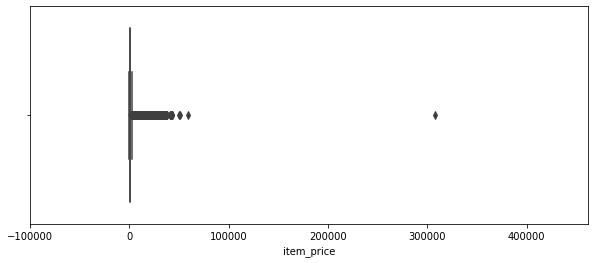

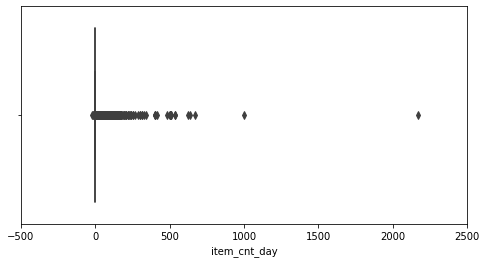

In [118]:
# explore the item_price variable outliers
print(f"item_price: maximum price is {max(df_train.item_price)}, mininum price is {min(df_train.item_price)}")
plt.figure(figsize=(10,4))
plt.xlim(-100000, 1.5*max(df_train.item_price))
sns.boxplot(x=df_train.item_price)
# explore the item_cnt_day variable
print(f"item_cnt_day: maximum amounts is {max(df_train.item_cnt_day)}, mininum amounts is {min(df_train.item_cnt_day)}")
plt.figure(figsize=(8,4))
plt.xlim(-500,2500)
sns.boxplot(x=df_train.item_cnt_day)


In [119]:
# one outlier from item_price and item_cnt_day
print('Item price outliers:', df_train.item_id[df_train["item_price"]>100000])
print('Sales outliers:', df_train.item_id[df_train['item_cnt_day']>1000])

Item price outliers: 1163158    6066
Name: item_id, dtype: int16
Sales outliers: 2909818    11373
Name: item_id, dtype: int16


In [120]:
df_high_sales=pd.DataFrame(df_train.groupby("item_id").item_cnt_day.sum().sort_values(ascending=False).head(5)).reset_index()
df_low_sales=pd.DataFrame(df_train.groupby("item_id").item_cnt_day.sum().sort_values().head(5)).reset_index()
print(f'The best seller of item ID is {df_high_sales.item_id[0]} and the sale volume is {df_high_sales.item_cnt_day[0]}')
print(f'The worst seller of item ID is {df_low_sales.item_id[0]} and the sale volume is {df_low_sales.item_cnt_day[0]}')

The best seller of item ID is 20949 and the sale volume is 187642.0
The worst seller of item ID is 1590 and the sale volume is -11.0


### we should further investigate the reason that several items have negative sale volumns? 

## What other information we can derive from the feature of item_id
### 1. best and worst sale item
### 2. item_id mapping to item_category_id

## 1.2 Item_category_id
We next investigate the item_category_id info as it is highly relevant to item_id

In [121]:
print(f'The number of item categories is {cats.item_category_name.nunique()}')

The number of item categories is 84


In [122]:
# merge two dataset 
df_train_mod=pd.merge(df_train, items, on='item_id', how='inner')
# update by removing item_name
df_train_mod.drop(columns="item_name", inplace=True)

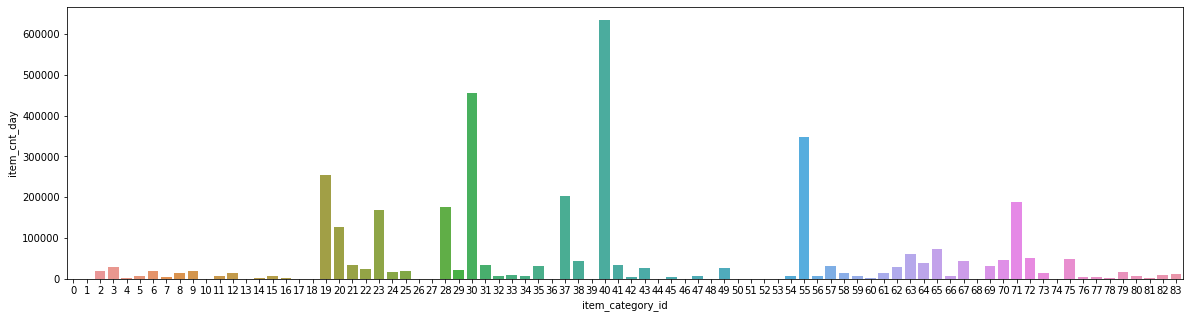

In [123]:
# sales amounts by category
sales_by_category=pd.DataFrame(df_train_mod.groupby('item_category_id')['item_cnt_day'].sum().sort_values()).reset_index()
# plot
fig=plt.subplots(figsize=(20,5))
sns.barplot(data=sales_by_category, y="item_cnt_day", x="item_category_id")
plt.show()

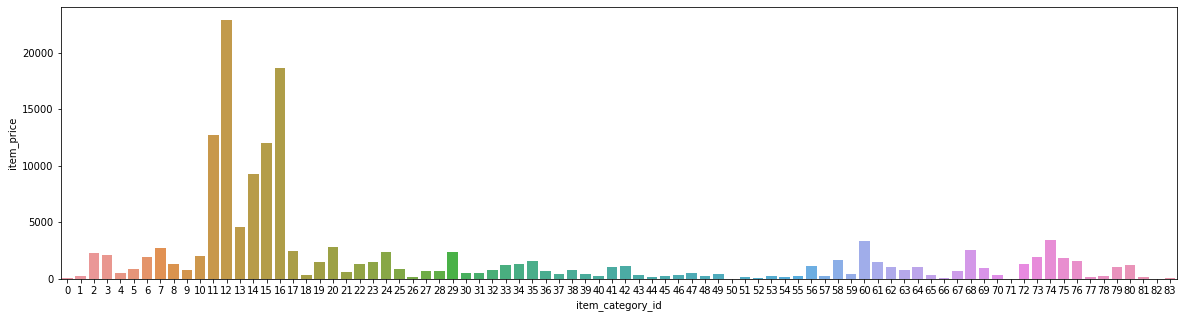

In [124]:
# average price of each category item
price_by_category=pd.DataFrame(df_train_mod.groupby("item_category_id")["item_price"].mean().sort_values()).reset_index()
# plot
fig=plt.subplots(figsize=(20,5))
sns.barplot(data=price_by_category, x="item_category_id", y="item_price")
plt.show()

## 1.3 shop_id

In [125]:
# The number of shops
print(f"There are totally {shops.shop_name.nunique()} shops")

There are totally 60 shops


In [126]:
sales_by_shop=df_train.pivot_table(index=["shop_id"], values=["item_cnt_day"], columns=["date_block_num"], aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop.columns=sales_by_shop.columns.droplevel().map(str)
sales_by_shop=sales_by_shop.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop.columns.values[0]="shop_id"

## what questions can be raised from the feature of shop_id
### six month rolling average of sales by shop
### shops with zero sales in consecutive six month
### sales trending (rising or declining) by shops
### best and worst shop


In [127]:
# update dataframe
sales_by_shop.drop(columns="shop_id", inplace=True)

In [128]:
sales_by_shop.index.name="shop_id"

In [129]:
# rolling average
rolling_sales_by_shop=sales_by_shop.rolling(6, axis=1).mean()


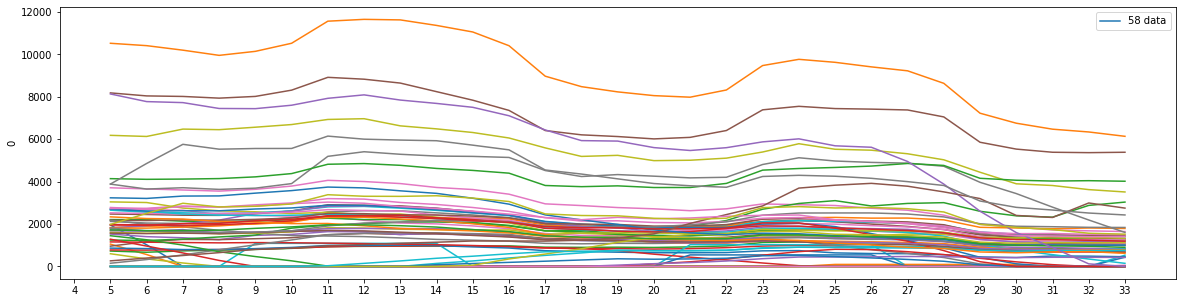

In [130]:
# graph, need to fix the legend problem
fig=plt.subplots(figsize=(20,5))
for i in range(0,59):
    sns.lineplot(data=rolling_sales_by_shop.loc[i,])
    plt.legend(["{} data".format(i)])

In [131]:
# rolling average equal to 0
for i in range(5, 33):
    print(f"At {i+1}th month, the shops ID that has rolling average equal to 0:", list(rolling_sales_by_shop.index[rolling_sales_by_shop[str(i)]==0]))
    

At 6th month, the shops ID that has rolling average equal to 0: [9, 11, 20, 33, 34, 36, 39, 40, 48, 49]
At 7th month, the shops ID that has rolling average equal to 0: [9, 11, 20, 33, 34, 36, 39, 40, 48, 49]
At 8th month, the shops ID that has rolling average equal to 0: [0, 1, 9, 11, 20, 33, 34, 36, 39, 40, 48, 49]
At 9th month, the shops ID that has rolling average equal to 0: [0, 1, 9, 11, 20, 33, 34, 36, 39, 40, 48, 49]
At 10th month, the shops ID that has rolling average equal to 0: [0, 1, 8, 11, 20, 23, 33, 34, 36, 39, 40, 48, 49]
At 11th month, the shops ID that has rolling average equal to 0: [0, 1, 8, 11, 20, 23, 33, 34, 36, 39, 40, 48, 49]
At 12th month, the shops ID that has rolling average equal to 0: [0, 1, 8, 11, 20, 23, 33, 34, 36, 39, 40, 48]
At 13th month, the shops ID that has rolling average equal to 0: [0, 1, 8, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48]
At 14th month, the shops ID that has rolling average equal to 0: [0, 1, 8, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48]
A

## 1.4 Price
### what can get from price feature. 
### the correlation between price and sales 
### discount can promote sales
### possible outliers

In [132]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [133]:
# the correlation between average item price and average item_cnt_day
item_price=df_train.groupby("item_id").mean()["item_price"]
item_sale=df_train.groupby("item_id").sum()["item_cnt_day"]
print("the correlation of average item price and total item sale: {}".format(np.corrcoef(item_price, item_sale)[1,0]))
# the correlation indicate that item price has no significant effect on item sales.
# is it possible some of the item price goes down with time possibly item is discounted 

# the most expensive and least expensive item price. 
print("The highest price among all items is {}".format(df_train['item_price'].max()))
print("The lowest price among all items is {}".format(df_train['item_price'].min()))
# the item price of -1 should be outlier to be removed
# possbily dig into why there are some items with such low price. outlier or normal?
print("the number of item price below 1 is {}".format(sum(df_train['item_price']<1)))

df_train["item_price"].sort_values(ascending=True).head(15)

the correlation of average item price and total item sale: 0.004902512488473324
The highest price among all items is 307980.0
The lowest price among all items is -1.0
the number of item price below 1 is 4658


484683   -1.0000
608763    0.0700
579766    0.0700
611400    0.0875
673155    0.0900
745118    0.1000
546031    0.1000
546032    0.1000
546033    0.1000
546034    0.1000
546072    0.1000
546073    0.1000
546074    0.1000
546075    0.1000
546076    0.1000
Name: item_price, dtype: float32

## 1.5 Dates feature
### how to convert date column to time stamp
### weekends and holiday sales 

In [134]:
# pandas convert object to timestamp.
pd.to_datetime(df_train['date'][1])

Timestamp('2013-03-01 00:00:00')

## 1.6 Shop info
### this part of code is copied from https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data


In [135]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


some shops have duplicated id/name, probably it changed location (within commercial center), or it has a different type (isle sale point).

In [136]:
shops['shop_name']=shops['shop_name'].apply(lambda x:x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city']=shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,shop_name,shop_id,shop_city,shop_type
0,якутск орджоникидзе фран,0,якутск,NO_DATA
1,якутск тц центральный фран,1,якутск,тц
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрькиномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц


split shop name into shop name, shop city and shop type

## 1.7 item feature
### temporarily copy from https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data

In [137]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [138]:
from collections import Counter
from operator import itemgetter
items['name_1'], items['name_2']=items['item_name'].str.split('[',1).str
items['name_1'], items['name_3']=items['item_name'].str.split('(',1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys



After learn basic EDA method, I will learn some basic machine learning models by copying and modifying the following kernel.

https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda



### list of dataset
1. df_train
2. items
3. shops
4. cats

In [139]:
# reinput the data 

df_train=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
items=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
shops=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
cats=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')

In [140]:
print(df_train.head(),'\n')
print(items.head(),'\n')
print(shops.head(),'\n')
print(cats.head(),'\n')

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0 

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40   

                        shop_